# Práctico 2

Integrantes:

* Finzi, Nadia
* Villafañe, Roxana Noelia

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

In [ ]:
#import pandas as pd
#from pathlib import Path

## Descargar el csv con los datos en este directorio
#DATA_DIR = Path('../data/twitter')
#INPUT_FILE = DATA_DIR / 'vacunas.csv'

## Creamos el directorio en caso de que no exista
#DATA_DIR.mkdir(parents=True, exist_ok=True)

## Configuración inicial

In [ ]:
# seteo de entorno
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#%cd /content/drive/My\ Drive/grafos/

In [ ]:
# Varios
import pandas as pd
import networkx as nx
import igraph #importamos igraph
from igraph import Graph
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pylab


# Clustering
from cdlib import NodeClustering, evaluation, algorithms

# Comunidades
import community.community_louvain
import community
from community import community_louvain
import community as community_louvain

# Embeddings
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Drive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials


In [ ]:
sns.set_context('talk')

In [ ]:
def plot_graph(g, comms, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    colors = np.zeros(g.number_of_nodes(), dtype='int')
    for comm, node in enumerate(comms):
        colors[node] = comm

    pos = nx.spring_layout(g, seed=22)
    nx.draw(
        g, with_labels=True, pos=pos, node_color=colors, cmap='Set2', 
        ax=ax
    )
    return ax

def plot_graph_by_parameters(g, comms_dict, parameter_name):
    ncols = len(comms_dict)
    fig, axes = plt.subplots(figsize=(8*ncols, 10), ncols=ncols)
    for i, (param, comms) in enumerate(comms_dict.items()):
        ax = axes[i]
        comms = comms_dict[param]
        Q = evaluation.newman_girvan_modularity(g, comms).score
        ax.set_title(f'{parameter_name}: {param:.3f}\nQ = {Q:.3f}')
        plot_graph(g, comms.communities, ax=ax)
    fig.suptitle(f'Algoritmo de {comms.method_name}', fontsize=28)
    return fig, axes 

def create_contingency_table(comms1, comms2):
    """
    Compute contingency table between partition comms1 and
    partition comms2.
    
    The contingency table is defined by
    
    n_{kk'} = |C_k \cap C'_{k'}|.
    """
    table = np.zeros((len(comms1), len(comms2)))
    for i, c1 in enumerate(comms1):
        for j, c2 in enumerate(comms2):
            table[i,j] = len(set(c1).intersection(c2))
    return table

def get_all_node_properties(g):
    """
    Return a set of all node properties of the graph.
    """
    node_props = set()
    for v in g.nodes():
        node_props = node_props.union(set(g.nodes[v].keys()))
    return node_props

def get_membership(comms):
    """
    Devuelve un vector de N elementos, donde el i-ésimo elemento
    corresponde a la etiqueta de la comunidad correspondiente
    al nodo i.
    """
    if isinstance(comms, NodeClustering):
        comms = comms.communities
    N = sum(len(c) for c in comms)
    membership = np.zeros(N, dtype='int')
    for c, nodes in enumerate(comms):
        membership[nodes] = c
    return membership

def get_comparison_matrix(comms1, comms2):
    """
    Construye la matriz de comparación entre particiones. 
    La matriz de comparación es una matriz de 2x2 cuyos 
    elementos están definidos de la siguiente manera:
    
    M_{11}: # pares de nodos que están en la misma comunidad en 'comms1' y 'comms2'
    M_{00}: # pares de nodos que están en distintas comunidades en 'comms1' y 'comms2'
    M_{10}: # pares de nodos que están en la misma comunidad en 'comms1' pero no en 'comms2' 
    M_{01}: # pares de nodos que están en la misma comunidad en 'comms2' pero no en 'comms1'
    """
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    membership1 = get_membership(comms1)
    membership2 = get_membership(comms2)
    N = len(membership1)
    M = np.zeros((2,2), dtype='int')
    for i in range(N):
        for j in range(i+1, N):
            if membership1[i] == membership1[j]:
                if membership2[i] == membership2[j]:
                    M[1,1] += 1
                else:
                    M[1,0] += 1
            else:
                if membership2[i] == membership2[j]:
                    M[0,1] += 1
                else:
                    M[0,0] += 1
    return M

def rand_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return (M[0,0] + M[1,1]) / M.sum()

def jaccard_index(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    M = get_comparison_matrix(comms1, comms2)
    return M[0,0] / (M[1,1] + M[1,0] + M[0,1])

def mutual_information(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    table = create_contingency_table(comms1, comms2)
    table = table / table.sum()
    MI = 0
    for k1, comm1 in enumerate(comms1):
        for k2, comm2 in enumerate(comms2):
            if table[k1, k2] == 0:
                continue
            pk1 = table.sum(axis=1)[k1]
            pk2 = table.sum(axis=0)[k2]
            if (pk1 == 0) or (pk2 == 0):
                continue
            MI += table[k1, k2] * np.log2(table[k1, k2] / (pk1*pk2))
    return MI

def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict

def plot_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = run_louvain(g, 0.01, 10, samples=200)
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

In [ ]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

In [ ]:
'''
def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename, dtype = dtypes)

drive = connect_to_drive() 

df = read_csv_from_drive(drive, '1ecOBly_KJp5GCDOOE3_Rs8F3L3p_QJRk', 'vacunas.csv').dropna(subset=['user_retweeters'])
etiquetas = read_csv_from_drive(drive, '1qXme18gwQKQ-7N2BevqLf4jAKvH4utLG', 'etiquetas.csv')
'''

"\ndef connect_to_drive():\n  auth.authenticate_user()\n  gauth = GoogleAuth()\n  gauth.credentials = GoogleCredentials.get_application_default()\n  return GoogleDrive(gauth)\n\ndef read_csv_from_drive(drive, id, filename):\n  downloaded = drive.CreateFile({'id':id}) \n  downloaded.GetContentFile(filename)  \n  return pd.read_csv(filename, dtype = dtypes)\n\ndrive = connect_to_drive() \n\ndf = read_csv_from_drive(drive, '1ecOBly_KJp5GCDOOE3_Rs8F3L3p_QJRk', 'vacunas.csv').dropna(subset=['user_retweeters'])\n"

# Importación de dataframes

In [ ]:
df=pd.read_csv('vacunas.csv', dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


In [ ]:
dff = df[['user.id', 'user_retweeters']]
dff.head()

,user.id,user_retweeters
0,2737379453,"[2258074658, 159909978, 105301854, 290671142, ..."
1,32718111,[]
2,252168075,"[1238117630696972289, 37232479, 12792246571247..."
3,1156346340802224128,[]
4,153663816,[]


In [ ]:
df_final = dff.explode('user_retweeters')
df_final.head()

,user.id,user_retweeters
0,2737379453,2258074658
0,2737379453,159909978
0,2737379453,105301854
0,2737379453,290671142
0,2737379453,208721168


In [ ]:
df_final.shape

(320948, 2)

In [ ]:
#debemos remover los NaNs
df_final = df_final.dropna()
df_final.shape

(187297, 2)

In [ ]:
etiquetas = pd.read_csv("etiquetas.csv", dtype=dtypes)
etiquetas

,user.id,Clase
0,1227432088925851650,0
1,1148843472,0
2,1329815581302853632,0
3,131669966,0
4,811607948,0
...,...,...
191,15750760,1
192,882731195834003457,1
193,164350783,1
194,1249892637085237258,1


In [ ]:
df_final = pd.merge(df_final.reset_index(drop=True), etiquetas, on = "user.id", how = "left")
df_final

,user.id,user_retweeters,Clase
0,2737379453,2258074658,NaN
1,2737379453,159909978,NaN
2,2737379453,105301854,NaN
3,2737379453,290671142,NaN
4,2737379453,208721168,NaN
...,...,...,...
187292,437640516,1314707677096927234,NaN
187293,58065646,353854993,NaN
187294,79840600,1363288094,NaN
187295,79840600,2258074658,NaN


# **4. Extracción de etiquetas**

En el archivo [etiquetas.csv](https://drive.google.com/file/d/1LWY3VoIRt0xKwEbbtMXYePOGZvgPsQh-/view?usp=sharing) están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

- Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
- Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.

**Opcional:** Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

- Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
- Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados.

In [ ]:
users_nodes = pd.read_csv('node_centrality.csv', dtype=dtypes)
users_nodes = users_nodes.rename(columns={"Unnamed: 0":"user.id"})
users_nodes["user.id"] = users_nodes["user.id"].astype(str)
users_nodes

,user.id,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central,strength
0,2737379453,9,0.000000,78111.640852,0.000748,0.244898,0.000038,0.250772,9.0
1,2258074658,19,0.052632,130535.561685,0.009091,0.286305,0.000070,0.307703,19.0
2,159909978,1,0.000000,0.000000,0.000007,0.196722,0.000007,0.198210,1.0
3,105301854,10,0.066667,31376.713412,0.010696,0.304398,0.000036,0.325685,10.0
4,290671142,15,0.066667,291383.100735,0.011937,0.308014,0.000056,0.329096,15.0
...,...,...,...,...,...,...,...,...,...
39795,2765081259,1,0.000000,0.000000,0.000000,1.000000,0.000025,0.000025,1.0
39796,339254354,6,0.000000,42429.139015,0.000476,0.276895,0.000031,0.281808,6.0
39797,346605471,1,0.000000,0.000000,0.000005,0.216851,0.000008,0.217565,1.0
39798,58065646,1,0.000000,0.000000,0.000251,0.239956,0.000006,0.246824,1.0


In [ ]:
users = pd.merge(users_nodes, etiquetas, on = "user.id", how = "left")
usuarios = users[users.Clase.notna()]
usuarios

,user.id,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central,strength,Clase
4,290671142,15,0.066667,2.913831e+05,0.011937,0.308014,0.000056,0.329096,15.0,0.0
10,252168075,8207,0.000558,2.703364e+08,0.738339,0.392229,0.040722,0.478310,8207.0,0.0
44,156054222,16,0.183333,9.701517e+04,0.012395,0.313466,0.000062,0.333574,16.0,0.0
87,73102744,5362,0.000496,1.259533e+08,0.972362,0.371290,0.030866,0.434693,5362.0,1.0
180,3421061763,129,0.066742,3.921530e+06,0.081335,0.372813,0.000552,0.399625,129.0,1.0
...,...,...,...,...,...,...,...,...,...,...
34918,33024510,1,0.000000,0.000000e+00,0.007162,0.276506,0.000009,0.288382,1.0,1.0
36259,3107864708,13,0.141026,4.006898e+04,0.009286,0.300393,0.000046,0.319873,13.0,0.0
37733,983848121754058752,1,0.000000,0.000000e+00,0.003618,0.258740,0.000010,0.269102,1.0,1.0
39059,1253116205788991489,1,0.000000,0.000000e+00,0.003220,0.254959,0.000009,0.262236,1.0,1.0


In [ ]:
usuarios[usuarios.Clase == 0].sort_values("degree", ascending=False)["user.id"].head(10)

0              252168075
1              510740590
2              145493922
3              484349869
4    1272713534078619648
5               43814969
6    1092059695383281666
7              145010134
8              405924380
9               35961319
Name: user.id, dtype: object

In [ ]:
def primeros_10(columna, clase):
    return usuarios[usuarios.Clase == clase].sort_values(columna, ascending=False).reset_index(drop=True)["user.id"].head(10)

referentes_0 = pd.DataFrame()  
referentes_1 = pd.DataFrame()  


for columna in ["degree","Cws","betweenness","eigenvector","closeness","page_rank","harm_central"]:
    referentes_0[columna] = primeros_10(columna, 0)
    referentes_1[columna] = primeros_10(columna, 1)
    

## 4.1. Referentes de cada clase

In [ ]:
referentes_0

,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central
0,252168075,140374618,252168075,252168075,252168075,252168075,252168075
1,510740590,2947569093,510740590,510740590,510740590,510740590,510740590
2,145493922,973491850530164736,145493922,145493922,145493922,43814969,145493922
3,484349869,172417422,484349869,484349869,1043343131272462336,145493922,1043343131272462336
4,1272713534078619648,811607948,43814969,1272713534078619648,145010134,484349869,2229279600
5,43814969,1239291711299428353,1272713534078619648,43814969,1272713534078619648,1272713534078619648,145010134
6,1092059695383281666,4422267497,927377684224708608,145010134,2229279600,1092059695383281666,1272713534078619648
7,145010134,1426566756,1092059695383281666,1092059695383281666,202984292,145010134,202984292
8,405924380,1340629915176226825,145010134,4470440536,43814969,405924380,43814969
9,35961319,939907866894401536,869206764704731136,405924380,1308513159171407880,35961319,1308513159171407880


In [ ]:
referentes_1

,degree,Cws,betweenness,eigenvector,closeness,page_rank,harm_central
0,73102744,910956876686381058,73102744,73102744,206371045,73102744,73102744
1,367933714,146631761,367933714,367933714,367933714,367933714,367933714
2,2687724840,1212718019849248768,2687724840,2687724840,3421061763,2687724840,206371045
3,3421061763,1183974626,206371045,3421061763,73102744,4160782817,2687724840
4,4160782817,2693592596,3421061763,4160782817,2687724840,3421061763,3421061763
5,1146448109070966784,378996603,4160782817,1146448109070966784,1146448109070966784,1146448109070966784,1146448109070966784
6,1014284625592639489,202824848,1146448109070966784,206371045,4160782817,837186873143488514,4160782817
7,837186873143488514,1163194886352461824,837186873143488514,1172610671965548545,268488742,1014284625592639489,268488742
8,206371045,4696317872,268488742,268488742,1172610671965548545,206371045,1172610671965548545
9,1172610671965548545,1351621913446141953,1172610671965548545,837186873143488514,1351621913446141953,176605247,1351621913446141953


## Tuits principales de la clase 0 

In [ ]:
df[df["user.id"] == "252168075"].full_text.unique()

array(['Bueno, Alberto dijo Salud o Economía. La salud para ellos, la ruina económica para nosotros. No aclaró.',
       'No Kichi: no fue una espantosa campaña anti vacunas. Vos y tu esposa no lo entenderían jamas.',
       'Un economista y una doctora en letras. Por dios. No entendieron nada. BURROS.',
       ...,
       '"Researchers worry that efforts to free up limited vaccine doses are driven by desperation rather than data." Acá ni tenemos data! https://t.co/fUmcr2YRsR',
       'La mina que grita me resulta tan truchex. Mas que la vacuna rusa. https://t.co/2qjsTUBJA8',
       'Hacétee cargo vos de todo lo que decís, payaso. Vos seguro recibiste la Pfizer o la Moderna. https://t.co/iHDDuwyRGO'],
      dtype=object)

In [ ]:
df[df["user.id"] == "510740590"].full_text.unique()


array(['@spitta1969 Excelente aporte, Sandra. Cierto, ya de eso no se habla porque cada día hay un escándalo que tapa a otro, pero es bueno divulgar esta informaci´n, que viene de los propios científicos rusos',
       '@spitta1969 Estos son los qui militan la vacuna rusa...',
       '@spitta1969 Y además de todo, no hay vacunas. Ni de a Sputnik ni de ninguna. Qué gran"gobierno de científicos"...',
       '@ArielCaete1 @spitta1969 No te da vergüenza escribir tweets tan ridículos , Ariel? Porqué repetis slogans mentirosos sin entender nada? De paso: de Sandra Pitta podrías aprender mucho, seguila...',
       '@SStradolini @spitta1969 Juatamente, la información que reclamamos para la Sputnik, y que ni siquiera post Lancet no la tenemos, es para generar ese "mensaje claro". porque una vacuna se aprueba con base científica. No con opiniones de políticos o "militantes"',
       '@spitta1969 Y si fuera verdad? Demostración de que empezaron a usarla acá antes de tener su dossier completo....'

## Tuits principales de la clase 0 

In [ ]:
df[df["user.id"] == "73102744"].full_text.unique()

array(['Argentina tiene hoy casi 18 muertos por millón por semana, es decir, un millón de vacunas salvarían al menos 18 vidas *en cada semana* después de producir inmunidad (en realidad bastante más si la vacuna va a mayores de 65 años, ya que es el grupo con más muertes).',
       '@arroadri Inevitable a menos que se aceleren las vacunas',
       '@jadagui un rato, me cayeron los violentos', ...,
       '@HumbertoCisale Claro, debe pensar que es como las notas de Natasha Niebieskikwiat',
       '@HugoBlancoHB 🥰',
       '@niqueco @GuilledAnillaco @rquiroga777 @beabusaniche Porque además la historia es que Berlich dijo que yo era un mal judío cuando el acuerdo con Irán, y yo le dije que los que patrullaban el gueto decidiendo cuál era el judío bueno y quién era el malo eran los judenrat.'],
      dtype=object)

In [ ]:
df[df["user.id"] == "367933714"].full_text.unique()

array(['@pimboleto @ernestorr 7 millones entre &gt;70 y &gt;60 y unos 8 millones de 18-59 con comorbilidades',
       '@pimboleto @ernestorr Yo firmo por 8',
       'Adolfo muy seriamente aborda la situación de Brasil y las fronteras. Comparte la mayoría de lo que dijimos en la carta. Restringir a fondo o nada. Lo intermedio no sirve, y la situación en Brasil asusta.\n\nAlgo gracioso, los mismos que criticaron nuestra carta le dan like y RT. 😂 https://t.co/evtDpTidaM',
       '@tomaydale Uno espera infructuosamente cierta honestidad intelectual de parte de científicos.\n\nEra una (última?) oportunidad de hacer un pedido amplio y razonable sin teñirlo de partidismo, pero prevaleció la idea de descalificar al interlocutor a pesar de coincidir en el mensaje. 🤷\u200d♂️',
       '@riverapomar @tomaydale Hola Rolando, no era sólo por vos, pero veo más voluntad de criticar detalles que de coincidir en el mensaje central.\n\nY no sólo en tu caso, sino en general con varios científicos tuiteros

In [ ]:
### Armamos el grafo

In [ ]:
df_etiquetados = df_final.dropna().reset_index(drop=True)
df_etiquetados

,user.id,user_retweeters,Clase
0,252168075,1238117630696972289,0.0
1,252168075,37232479,0.0
2,252168075,1279224657124753408,0.0
3,252168075,1299172647583051777,0.0
4,252168075,920281298735976449,0.0
...,...,...,...
86516,484349869,1196548869619953671,0.0
86517,484349869,1193738128412102657,0.0
86518,484349869,315827796,0.0
86519,484349869,252168075,0.0


In [ ]:
edges = pd.DataFrame({"source": df_etiquetados['user.id'],
                      "target": df_etiquetados['user_retweeters']})

In [ ]:
G = nx.from_pandas_edgelist(edges,
                            source='source', 
                            target='target')

In [ ]:
print(nx.info(G))

Graph with 17915 nodes and 22550 edges


In [ ]:
### Armamos las comunidades

# Elegimos la resolución igual a 10 porque era la que nos permitía agrupar en dos grandes comunidades.

In [ ]:
coms = algorithms.louvain(G, resolution=10, randomize=False)
print(coms)

In [ ]:
len(coms.communities)

4

In [ ]:
for i in coms.communities:
    print(len(i))

9703
8208
2
2


Vemos que nos quedaron 4 comunidades definidas: 2 grandes con la mayoría de la gente, distribuidos casi equitativamente, y dos comunidades pequeñas con 2 personas cada una.

In [ ]:
### Cruzamos los datos de las comunidades asignadas con las etiquetas originales

In [ ]:
df_por_usuario = pd.DataFrame({"user.id": coms.communities})
df_por_usuario = df_por_usuario.reset_index()
df_por_usuario.rename(columns={"index": "grupo"}, inplace = True)
df_por_usuario = df_por_usuario.explode('user.id')
df_por_usuario.reset_index(drop=True, inplace = True)
df_completo = pd.merge(df_por_usuario, df_etiquetados, on = "user.id", how = "left")
df_completo

,grupo,user.id,user_retweeters,Clase
0,0,73102744,178105343,1.0
1,0,73102744,2644056245,1.0
2,0,73102744,4196856351,1.0
3,0,73102744,215547565,1.0
4,0,73102744,146536143,1.0
...,...,...,...,...
104307,1,315827796,NaN,NaN
104308,2,2846083090,1624241750,1.0
104309,2,1624241750,NaN,NaN
104310,3,312855179,1246062412090019845,1.0


In [ ]:
clasificacion_usuarios = df_completo.dropna().drop_duplicates("user.id")
clasificacion_usuarios

,grupo,user.id,user_retweeters,Clase
0,0,73102744,178105343,1.0
23213,0,3421061763,713923104989388800,1.0
23386,0,910956876686381058,886733270230216706,1.0
23389,0,367933714,2601817933,1.0
34429,0,2687724840,889693274,1.0
...,...,...,...,...
103305,1,1250601378872991745,1071973252774404096,0.0
103466,1,2223272358,1238594246929715200,0.0
103730,1,3107864708,734388470458818561,0.0
104308,2,2846083090,1624241750,1.0


In [ ]:
clasificacion_usuarios.to_csv("usuarios_clasificados.csv")

## 4.2. Comparación entre comunidades asignadas y etiquetas de clases originales

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

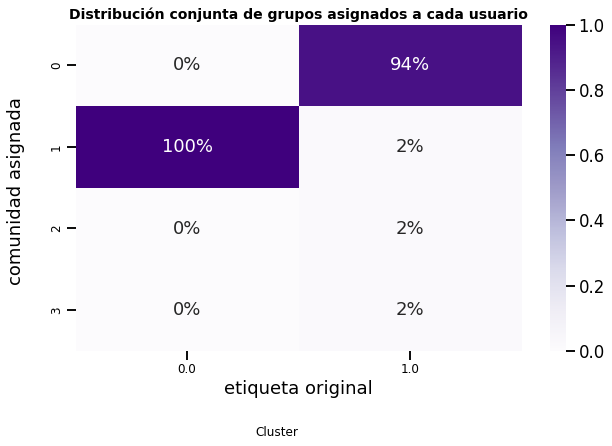

In [ ]:
fig = plt.figure(figsize=(10,6))
exp = pd.crosstab(
    clasificacion_usuarios['grupo'],
    clasificacion_usuarios['Clase'],
    normalize='columns'
)
sns.heatmap(exp, annot=True, fmt='0.0%', cmap='Purples')
plt.xlabel("etiqueta original")
plt.ylabel("comunidad asignada \n")
plt.title("Distribución conjunta de grupos asignados a cada usuario", fontsize=14, weight='bold')
plt.annotate(
    'Cluster', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Vemos que los usuarios se mantuvieron en las mismas comunidades en las que se encontraban originalmente, salvo casos aislados que quedaron en la comunidad opuesta (2%), y los 4 usuarios que quedaron en las "nuevas" comunidades (2 y 3).

# **5. Embedding de nodos**

- Generar un embedding del grafo de retweets utilizando el algoritmo `word2vec`.
- Reducir a 2 la dimensionalidad del embedding utilizando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
- Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

**Opcional:** Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

## 5.1. Generación del embedding

In [ ]:
## Primera etapa
dim = 50
node2vec = Node2Vec(G, dimensions=dim, walk_length=5, num_walks=100, p=1, q=1, seed=22)
type(node2vec)

Computing transition probabilities:   0%|          | 0/17915 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████| 100/100 [29:01<00:00, 17.42s/it]


node2vec.node2vec.Node2Vec

In [ ]:
## Segunda etapa
model = node2vec.fit(window=4)
type(model)

gensim.models.word2vec.Word2Vec

In [ ]:
embedding = np.array([model.wv[str(idx)] for idx in G.nodes()])
embedding.shape

(17915, 50)

In [ ]:
model.wv.most_similar('252168075')

[('1082341778768973824', 0.9072145223617554),
 ('4449481547', 0.9022157788276672),
 ('452608976', 0.901215672492981),
 ('470810678', 0.9010207653045654),
 ('24153647', 0.9003616571426392),
 ('2603805908', 0.8997774124145508),
 ('1439319715', 0.8981743454933167),
 ('176590617', 0.8971544504165649),
 ('4838835292', 0.8967359662055969),
 ('4288397141', 0.8961555361747742)]

In [ ]:
model.wv.most_similar('73102744')

[('55339958', 0.9154979586601257),
 ('4428375419', 0.914296567440033),
 ('2961145895', 0.9142907857894897),
 ('705538482786213888', 0.9140573740005493),
 ('194071210', 0.9136673212051392),
 ('2877598333', 0.9129866361618042),
 ('623412196', 0.912947952747345),
 ('912310287696527360', 0.912386417388916),
 ('813804262614564868', 0.9120854735374451),
 ('1211371890062712832', 0.9120370745658875)]

## 5.2. Reducción de dimensionalidad

In [ ]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)


In [ ]:
etiqueta_0 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['Clase']==0]['user.id']))]
etiqueta_1 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['Clase']==1]['user.id']))]

comunidad_0 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['grupo']==0]['user.id']))] 
comunidad_1 = [i for i, v in enumerate(G.nodes()) if v in (list(clasificacion_usuarios[clasificacion_usuarios['grupo']==1]['user.id']))] 

## 5.3. Gráfico de embeddings

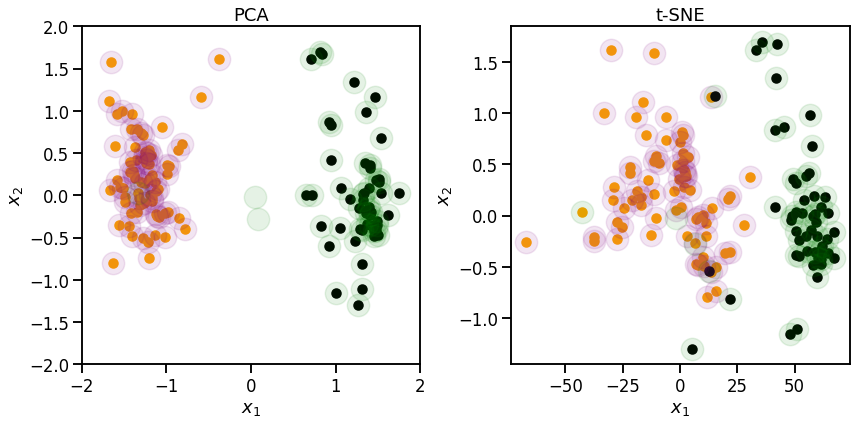

In [ ]:
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)


fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_title('PCA')
x, y = pca[comunidad_1][:,0],pca[comunidad_1][:,1]
ax.scatter(x,y, c='orange')
x, y = pca[comunidad_0][:,0],pca[comunidad_0][:,1]
ax.scatter(x,y, c='black')
x, y = pca[etiqueta_0][:,0],pca[etiqueta_0][:,1]
ax.scatter(x,y, c='purple', alpha = 0.1, s=500)
x, y = pca[etiqueta_1][:,0],pca[etiqueta_1][:,1]
ax.scatter(x,y, c='green', alpha = 0.1, s=500)


ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
x, y = tsne[comunidad_1][:,0],pca[comunidad_1][:,1]
ax.scatter(x,y, c='orange')
x, y = tsne[comunidad_0][:,0],pca[comunidad_0][:,1]
ax.scatter(x,y, c='black')
x, y = tsne[etiqueta_0][:,0],pca[etiqueta_0][:,1]
ax.scatter(x,y, c='purple', alpha = 0.1, s=500)
x, y = tsne[etiqueta_1][:,0],pca[etiqueta_1][:,1]
ax.scatter(x,y, c='green', alpha = 0.1, s=500)

plt.tight_layout()
plt.show()

## Conclusión

Como podemos observar en la figura anterior, se visualizan los agrupamientos correspondientes a las dos clases/comunidades en estudio. 

Originalmente, teníamos las etiquetas correspondientes a dos grupos (0 y 1), y luego, habiamos detectado 4 comunidades. Al realizar la matriz de confusión veíamos que había una coincidencia casi del 100% en todos los casos. 
Eso se observa y confirma en el gráfico anterior. 

Los puntos en el gráfico poseen una especie de contorno transparente que corresponde a la etiqueta original, y la parte llena del punto corresponde a la comunidad asignada. 

También sucede, en muy pocos casos, que el contorno difiere del relleno del punto, dando a entender que la comunidad asignada no es igual a la etiqueta original.


A su vez, en PCA los puntos correspondientes a cada clase se encuentran más separados que en tSNE.